# Set up packages and server

In [2]:
# specify the GPU
import os
os.environ['TORCH_HOME'] = 'your/own/cache/directory'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
# Data visualization
import plotly.express as px
from ipywidgets import interact

# Data processing
import pandas as pd
import numpy as np
import geopandas as gpd

# Model training
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import copy
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import timm
from sklearn.model_selection import GroupShuffleSplit
# import lightning as L
# from lightning import Trainer
# from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

# Others
import os
import sys
import gc
from pathlib import Path
import os.path


from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, matthews_corrcoef, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns
import random


from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

# project lib
PROJECT_SRC_PATH = os.path.join( '/workspace/workspace/ufo-prediction', 'src-RCA-UFO')
sys.path.append(PROJECT_SRC_PATH)
import dataset
import visualizations

In [5]:
torch.cuda.empty_cache()

In [6]:
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cuda:0
GPU: NVIDIA A100-PCIE-40GB


# 2. Load and preprocess the training and validation data

In [7]:
def extract_building_id(filepath):
    """
    Extracts the building ID from the given filepath string.
    Knowing that the building ID always contains an underscore and considering the filename
    format '[age_right]_[building_id]_[subscript].jpg', this function returns the 'building_id'.
    """
    # Isolate the filename from the filepath
    filename = filepath.split('/')[-1]
    # Split the filename at underscores
    parts = filename.split('_')
    # Considering the first part is age_right and the last part is the subscript with .jpg,
    # the building ID is everything in between.
    # Rejoin the middle parts to account for underscores within the building ID itself.
    building_id = '_'.join(parts[1:-1])
    return building_id

def get_age_bracket(age):
    if 1900 <= age <= 1924:
        return '1900-1924'
    elif 1925 <= age <= 1945:
        return '1925-1945'
    elif 1946 <= age <= 1959:
        return '1946-1959'
    elif 1960 <= age <= 1969:
        return '1960-1969'
    elif 1970 <= age <= 1984:
        return '1970-1984'
    elif 1985 <= age <= 1999:
        return '1985-1999'
    elif 2000 <= age <= 2050:
        return '2000-2050'
    else:
        return 'Unknown'  # For ages outside the specified brackets or if age couldn't be determined
    
def extract_age_and_name(filepath):
    filename = os.path.basename(filepath)  # Get the filename from the filepath
    age_and_name = filename.split('.')[0]  # Split by dot and take the first part
    age = ''.join(filter(str.isdigit, age_and_name))[:4]  # Extract first 4 digits for age
    if age:  # Ensure age string is not empty
        age = int(age)
        age_bracket = get_age_bracket(age)  # Get the age bracket
    else:  # Default age if no digits found
        age_bracket = 'Unknown'
    return age_bracket


age_bracket_to_int = {
    '1900-1924': 0,
    '1925-1945': 1,
    '1946-1959': 2,
    '1960-1969': 3,
    '1970-1984': 4,
    '1985-1999': 5,
    '2000-2050': 6
}

In [8]:
directories = [
    #Path('/workspace/workspace/ufo-prediction/image_data_NLD'),
    #Path('/workspace/workspace/ufo-prediction/image_data_ESP'),  # Add your second directory path here
    #Path('/workspace/workspace/ufo-prediction/image_data_FRA'),
    Path('/workspace/workspace/ufo-prediction/image_data_NLD_adv'),
    Path('/workspace/workspace/ufo-prediction/image_data_ESP_adv'),  # Add your second directory path here
    Path('/workspace/workspace/ufo-prediction/image_data_FRA_adv')
   # Add your third directory path here
]

filepaths = pd.Series(
    [item for directory in directories for item in directory.glob('**/*.jpg')],
    name='Filepath'
).astype(str)

age_brackets = pd.Series(filepaths.apply(lambda x: extract_age_and_name(x)), name='Age Brackets')
building_ids = pd.Series(filepaths.apply(extract_building_id), name='Building ID')

# Filter to exclude 'Unknown' age brackets and corresponding filepaths and building IDs
filtered_indices = age_brackets != 'Unknown'
filtered_age_brackets = age_brackets[filtered_indices]
filtered_filepaths = filepaths[filtered_indices]
filtered_building_ids = building_ids[filtered_indices]

# Create DataFrame
trainval_df = pd.concat([filtered_filepaths, filtered_age_brackets, filtered_building_ids], axis=1)
trainval_df = trainval_df.sample(frac=1.0, random_state=1).reset_index(drop=True)
trainval_df['Target'] = trainval_df['Age Brackets'].map(age_bracket_to_int)

print(trainval_df.head())

                                            Filepath Age Brackets  \
0  /workspace/workspace/ufo-prediction/image_data...    1946-1959   
1  /workspace/workspace/ufo-prediction/image_data...    1985-1999   
2  /workspace/workspace/ufo-prediction/image_data...    1970-1984   
3  /workspace/workspace/ufo-prediction/image_data...    1960-1969   
4  /workspace/workspace/ufo-prediction/image_data...    1970-1984   

                 Building ID  Target  
0   v0.1-FRA.10.4.1.1_1-6071       2  
1      v0.1-NLD.12.10_1-2634       5  
2  v0.1-ESP.12.4.3.27_1-1231       4  
3      v0.1-NLD.10.8_1-16964       3  
4       v0.1-NLD.2.3_1-12475       4  


In [9]:
len(trainval_df)

40391

In [10]:
# Initialize the GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=1)

# Split the DataFrame into training and validation+test sets
# We use 'Building ID' as the groups to keep images of the same building together
train_idx, val_idx = next(gss.split(trainval_df, groups=trainval_df['Building ID']))
train_df = trainval_df.iloc[train_idx]
val_df = trainval_df.iloc[val_idx]


# Check the sizes of each set and sample outputs
print("Training set size:", train_df.shape)
print("Validation set size:", val_df.shape)
print("\nSample training data:", train_df.head())
print("\nSample validation data:", val_df.head())


Training set size: (28339, 4)
Validation set size: (12052, 4)

Sample training data:                                             Filepath Age Brackets  \
0  /workspace/workspace/ufo-prediction/image_data...    1946-1959   
2  /workspace/workspace/ufo-prediction/image_data...    1970-1984   
3  /workspace/workspace/ufo-prediction/image_data...    1960-1969   
4  /workspace/workspace/ufo-prediction/image_data...    1970-1984   
5  /workspace/workspace/ufo-prediction/image_data...    1985-1999   

                 Building ID  Target  
0   v0.1-FRA.10.4.1.1_1-6071       2  
2  v0.1-ESP.12.4.3.27_1-1231       4  
3      v0.1-NLD.10.8_1-16964       3  
4       v0.1-NLD.2.3_1-12475       4  
5    v0.1-FRA.8.5.2.1_1-6573       5  

Sample validation data:                                              Filepath Age Brackets  \
1   /workspace/workspace/ufo-prediction/image_data...    1985-1999   
14  /workspace/workspace/ufo-prediction/image_data...    1925-1945   
16  /workspace/workspace/ufo-pr

In [11]:
def check_building_id_exclusivity(train_df, val_df):
    # Extract building IDs from each dataset into sets
    train_ids = set(train_df['Building ID'])
    val_ids = set(val_df['Building ID'])

    # Check for intersections between the sets
    train_val_intersection = train_ids.intersection(val_ids)


    # Report the results
    if not train_val_intersection:
        print("Check passed: No building ID appears in more than one dataset.")
    else:
        if train_val_intersection:
            print("Overlap found between training and validation datasets:", train_val_intersection)
     

# Example usage:
check_building_id_exclusivity(train_df, val_df)

Check passed: No building ID appears in more than one dataset.


In [12]:
class AgeBracketDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        image = Image.open(img_path).convert("RGB")
        label = int(self.dataframe.iloc[idx, -1])  # Assuming the label/target is in the third column

        if self.transform:
            image = self.transform(image)

        return image, label


In [13]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),  # ResNet-18 expects 224x224 inputs
    transforms.RandomHorizontalFlip(),  # A common form of augmentation
    #transforms.RandomRotation(15),  # Rotates the image by up to 15 degrees
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Randomly jitters color
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization
])

val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = AgeBracketDataset(train_df, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = AgeBracketDataset(val_df, transform=val_test_transforms)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

# 3. Train model

In [14]:
def train_and_evaluate_val_loss(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=50, patience=7):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_val_loss = float('inf')  # Initialize the best validation loss as infinity
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0
    early_stop = False

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0

        # Training phase
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {avg_val_loss:.4f}')
        
        scheduler.step(avg_val_loss)  # Learning rate scheduler step based on validation loss

        # Check for improvement based on validation loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Early stopping check
        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs.')
            early_stop = True
            break
    
    if not early_stop:
        print('Reached maximum epoch limit.')

    # Load best model weights based on lowest validation loss
    model.load_state_dict(best_model_wts)
    return best_val_loss  # Return the best validation loss achieved


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Best Parameters
batch_size = 32
learning_rate = 0.0005

# Initialize the model
model = models.resnet18(pretrained=True)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Replace the last fully connected layer to adapt to the number of classes (7 in this case)
num_classes = 7
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Unfreeze the final layer so it can learn during training
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True


model = model.to(device)
print(model)

# Setup DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Setup optimizer, criterion, and scheduler
optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.25, patience=2, verbose=True)

# Train the model
best_val_loss = train_and_evaluate_val_loss(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=20, patience=5)

print("Best Validation Loss:", best_val_loss)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1/20, Training Loss: 1.9042, Validation Loss: 1.8920
Epoch 2/20, Training Loss: 1.8540, Validation Loss: 1.9653
Epoch 3/20, Training Loss: 1.8408, Validation Loss: 1.9288
Epoch 4/20, Training Loss: 1.8321, Validation Loss: 1.9006
Epoch     4: reducing learning rate of group 0 to 1.2500e-04.
Epoch 5/20, Training Loss: 1.7713, Validation Loss: 1.8908
Epoch 6/20, Training Loss: 1.7398, Validation Loss: 1.8781
Epoch 7/20, Training Loss: 1.7156, Validation Loss: 1.8768
Epoch 8/20, Training Loss: 1.6935, Validation Loss: 1.8651
Epoch 9/20, Training Loss: 1.6728, Validation Loss: 1.8698
Epoch 10/20, Training Loss: 1.6526, Validation Loss: 1.9005
Epoch 11/20, Training Loss: 1.6417, Validation Loss: 1.8756
Epoch    11: reducing learning rate of group 0 to 3.1250e-05.
Epoch 12/20, Training Loss: 1.5832, Validation Loss: 1.8998
Epoch 13/20, Training Loss: 1.5643, Validation Loss: 1.9168
Early stopping triggered after 13 epochs.
Best Validation Loss: 1.8650614725183745


## 4. Prepare the Test DataLoader

In [16]:
directory = Path('/workspace/workspace/ufo-prediction/image_data')

filepaths = pd.Series(list(directory.glob(r'**/*.jpg')), name='Filepath').astype(str)
age_brackets = pd.Series(filepaths.apply(lambda x: extract_age_and_name(x)), name='Age Brackets')
building_ids = pd.Series(filepaths.apply(extract_building_id), name='Building ID')

filtered_indices = age_brackets != 'Unknown'
filtered_age_brackets = age_brackets[filtered_indices]
filtered_filepaths = filepaths[filtered_indices]
filtered_building_ids = building_ids[filtered_indices]


test_df = pd.concat([filtered_filepaths, filtered_age_brackets, filtered_building_ids], axis=1)
test_df = test_df.sample(frac=1.0, random_state=1).reset_index(drop=True)
test_df['Target'] = test_df['Age Brackets'].map(age_bracket_to_int)

In [17]:
from numpy import unique
building_ids = [extract_building_id(path) for path in filepaths]
print(len(unique(building_ids)))
print(len(test_df))

535
1181


In [18]:
test_dataset = AgeBracketDataset(test_df, transform=val_test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

          Metric  Actual Model  Random Model
0       Accuracy        0.2117        0.2185
1      Precision        0.3171        0.2171
2         Recall        0.2117        0.2185
3       F1-Score        0.2121        0.2176
4            MCC        0.0917       -0.0107
5  Cohen's Kappa        0.0848       -0.0107


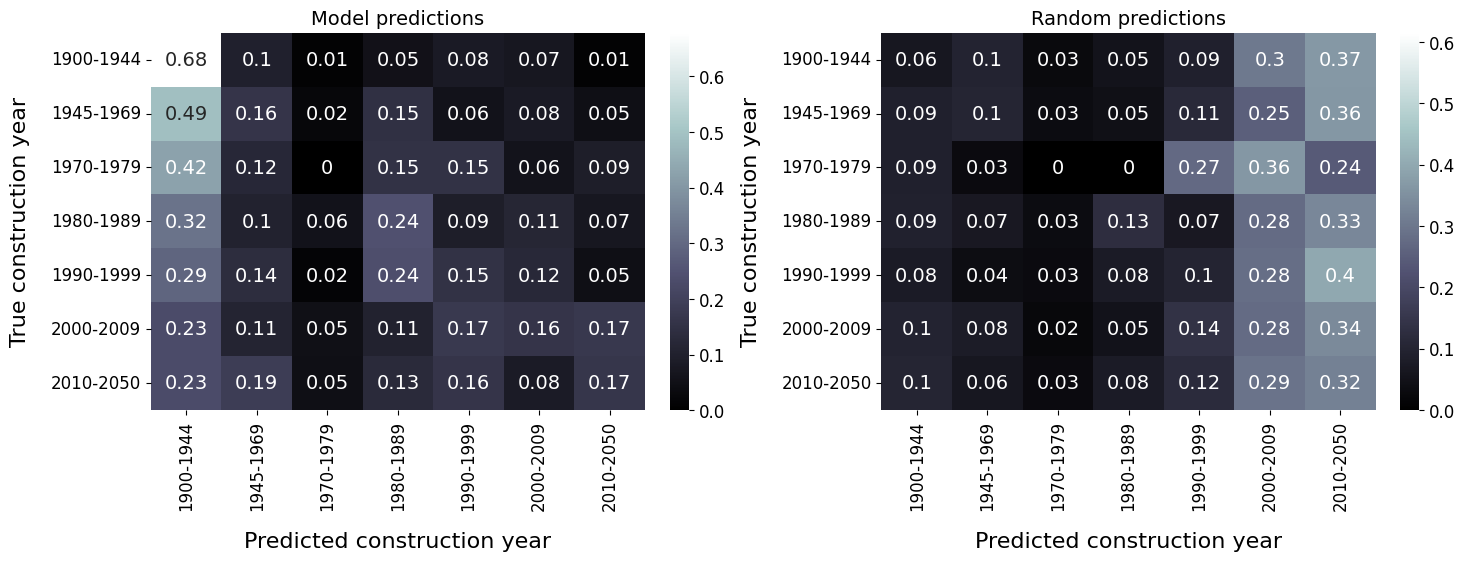

In [21]:
# Evaluate the actual model
model.eval()
true_classes = []
predicted_classes = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        true_classes.extend(labels.cpu().numpy())
        predicted_classes.extend(predicted.cpu().numpy())

true_classes = np.array(true_classes)
predicted_classes = np.array(predicted_classes)

# Generate random predictions
random_predictions = np.random.choice(np.unique(true_classes), size=len(true_classes), p=np.bincount(true_classes)/len(true_classes))

# Compute metrics for the actual model
accuracy = accuracy_score(true_classes, predicted_classes)
precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
mcc = matthews_corrcoef(true_classes, predicted_classes)
cohen_kappa = cohen_kappa_score(true_classes, predicted_classes)

# Compute metrics for the random model
rand_accuracy = accuracy_score(true_classes, random_predictions)
rand_precision, rand_recall, rand_f1, _ = precision_recall_fscore_support(true_classes, random_predictions, average='weighted')
rand_mcc = matthews_corrcoef(true_classes, random_predictions)
rand_cohen_kappa = cohen_kappa_score(true_classes, random_predictions)

# Compute the confusion matrices
# cm = confusion_matrix(true_classes, predicted_classes)
# rand_cm = confusion_matrix(true_classes, random_predictions)

# Create a DataFrame to hold the metrics for easier comparison
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'MCC', 'Cohen\'s Kappa'],
    'Actual Model': [np.round(accuracy, 4), np.round(precision, 4), np.round(recall, 4), np.round(f1, 4), np.round(mcc, 4), np.round(cohen_kappa, 4)],
    'Random Model': [np.round(rand_accuracy, 4), np.round(rand_precision, 4), np.round(rand_recall, 4), np.round(rand_f1, 4), np.round(rand_mcc, 4), np.round(rand_cohen_kappa, 4)]
})

# Display the DataFrame
print(metrics_df)


labels=['1900-1944', '1945-1969', '1970-1979', '1980-1989', '1990-1999', '2000-2009', '2010-2050']
_, axis = plt.subplots(nrows=1, ncols=2, figsize=(14.55, 5.5), constrained_layout=True)
visualizations.plot_confusion_matrix(true_classes,predicted_classes, class_labels=labels, title="Model predictions", ax=axis[0])
visualizations.plot_confusion_matrix_manual(true_classes,random_predictions, class_labels=labels, vmax=0.615, title="Random predictions", ax=axis[1])
plt.show()


# # Determine the maximum value for normalization of the heatmap colors
# vmax = max(np.max(cm), np.max(rand_cm))

# # Plot the confusion matrices side by side
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# # Confusion Matrix for Actual Model
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], vmin=0, vmax=vmax,
#             xticklabels=['1900-1944', '1945-1969', '1970-1979', '1980-1989', '1990-1999', '2000-2009', '2010-2050'],
#             yticklabels=['1900-1944', '1945-1969', '1970-1979', '1980-1989', '1990-1999', '2000-2009', '2010-2050'])
# axes[0].set_title('Confusion Matrix for Actual Model')
# axes[0].set_xlabel('Predicted Age Brackets')
# axes[0].set_ylabel('True Age Brackets')
# axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
# axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0)

# # Confusion Matrix for Random Model
# sns.heatmap(rand_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1], vmin=0, vmax=vmax,
#             xticklabels=['1900-1944', '1945-1969', '1970-1979', '1980-1989', '1990-1999', '2000-2009', '2010-2050'],
#             yticklabels=['1900-1944', '1945-1969', '1970-1979', '1980-1989', '1990-1999', '2000-2009', '2010-2050'])
# axes[1].set_title('Confusion Matrix for Random Model')
# axes[1].set_xlabel('Randomly predicted Age Brackets')
# axes[1].set_ylabel('True Age Brackets')
# axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
# axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0)

# plt.tight_layout()  # Adjust layout to not overlap
# plt.show()


In [22]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_path

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Assuming test_df is your DataFrame
test_dataset = CustomDataset(dataframe=test_df, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# 5. Infer age brackets

In [23]:
model.eval()  # Set the model to evaluation mode
probabilities_list = []
file_paths = []
predictions = []

with torch.no_grad():
    for inputs, paths in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probabilities = F.softmax(outputs, dim=1)  # Apply softmax to convert logits to probabilities
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        probabilities_list.extend(probabilities.cpu().numpy())  # Store probabilities
        file_paths.extend(paths)

# Assuming there are 6 classes, adjust the labels if different
class_labels = [f'Class_{i}' for i in range(probabilities.shape[1])]  # Adjust based on the softmax output size
predictions_df = pd.DataFrame(probabilities_list, columns=class_labels)
predictions_df['Predicted Class'] = predictions
predictions_df['FilePath'] = file_paths  # Add the file paths as a column in the DataFrame
# Extract building IDs and add them as a new column
predictions_df['id'] = predictions_df['FilePath'].apply(extract_building_id)

print(predictions_df.head())  # Display the first few rows of the DataFrame to check the output


    Class_0   Class_1   Class_2   Class_3   Class_4   Class_5   Class_6  \
0  0.036348  0.168654  0.070016  0.123498  0.220817  0.106286  0.274382   
1  0.254162  0.368745  0.080731  0.128740  0.059109  0.075824  0.032688   
2  0.249970  0.148112  0.099523  0.125311  0.148251  0.147155  0.081678   
3  0.173448  0.120052  0.103343  0.167904  0.151966  0.190878  0.092409   
4  0.115337  0.080308  0.191692  0.094431  0.108024  0.269658  0.140551   

   Predicted Class                                           FilePath  \
0                6  /workspace/workspace/ufo-prediction/image_data...   
1                1  /workspace/workspace/ufo-prediction/image_data...   
2                0  /workspace/workspace/ufo-prediction/image_data...   
3                5  /workspace/workspace/ufo-prediction/image_data...   
4                5  /workspace/workspace/ufo-prediction/image_data...   

                           id  
0   v0.1-ESP.8.1.3.10_1-36845  
1   v0.1-ESP.8.1.3.10_1-31985  
2        v0.1-

# 6. Concatenate Building ID and use to merge to rca-ufo dataset

In [24]:
unique_ids = predictions_df['id'].unique()
print(len(unique_ids))
print(len(predictions_df))


477
1181


In [25]:
# Calculate the sum of the probabilities for each class across all images for each building
sum_probs = predictions_df.groupby('id')[['Class_0', 'Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6']].sum()

# Normalize these sums so that the sum across all classes for each building equals 1
sum_probs_normalized = sum_probs.div(sum_probs.sum(axis=1), axis=0)

# Determine the predicted class for each building based on maximum confidence
# First, find the maximum probability for each class per building
max_conf_probs = predictions_df.groupby('id')[['Class_0', 'Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6']].max()

# Predicted class is the one with the highest maximum probability
max_conf_probs['Predicted Class'] = max_conf_probs.idxmax(axis=1).str.extract('(\d+)').astype(int)

# Now, get the first file path for each building as a representative path
# This assumes that the 'FilePath' was a column in predictions_df; if not, this line will fail
representative_file_paths = predictions_df.groupby('id')['FilePath'].first()

sum_probs_normalized.reset_index(inplace=True)
max_conf_probs.reset_index(inplace=True)


# Create the final DataFrame to have the normalized sums and the maximum confidence predicted class
final_results = pd.merge(sum_probs_normalized, max_conf_probs[['id', 'Predicted Class']], on='id', how='left')

print(final_results)


                            id   Class_0   Class_1   Class_2   Class_3  \
0     v0.1-ESP.1.3.4.5_1-26243  0.308417  0.156974  0.161959  0.107519   
1    v0.1-ESP.1.4.5.19_1-14679  0.215419  0.078266  0.082300  0.089532   
2    v0.1-ESP.1.4.5.19_1-14713  0.304378  0.079685  0.140955  0.048329   
3    v0.1-ESP.1.4.5.19_1-14739  0.104686  0.047633  0.063039  0.098770   
4    v0.1-ESP.1.4.5.19_1-15495  0.244871  0.095244  0.131371  0.075668   
..                         ...       ...       ...       ...       ...   
472       v0.1-NLD.9.4_1-91712  0.038743  0.120234  0.049750  0.096281   
473       v0.1-NLD.9.4_1-95511  0.249919  0.326919  0.127007  0.044307   
474       v0.1-NLD.9.4_1-95860  0.055255  0.125781  0.128281  0.162700   
475       v0.1-NLD.9.4_1-96708  0.134936  0.109178  0.152609  0.037410   
476      v0.1-NLD.9.62_1-12465  0.056707  0.126802  0.015821  0.018561   

      Class_4   Class_5   Class_6  Predicted Class  
0    0.130893  0.066356  0.067882                0  
1    

In [26]:
path_data_RCA = os.path.join(dataset.DATA_DIR, 'rca-ufo-merge_ALL.csv')
df = pd.read_csv(path_data_RCA, encoding='latin1')

In [27]:
print(len(df))

6141


In [28]:
final_results

,id,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Predicted Class
0,v0.1-ESP.1.3.4.5_1-26243,0.308417,0.156974,0.161959,0.107519,0.130893,0.066356,0.067882,0
1,v0.1-ESP.1.4.5.19_1-14679,0.215419,0.078266,0.082300,0.089532,0.168732,0.226545,0.139205,5
2,v0.1-ESP.1.4.5.19_1-14713,0.304378,0.079685,0.140955,0.048329,0.088606,0.295089,0.042959,0
3,v0.1-ESP.1.4.5.19_1-14739,0.104686,0.047633,0.063039,0.098770,0.315153,0.274256,0.096463,4
4,v0.1-ESP.1.4.5.19_1-15495,0.244871,0.095244,0.131371,0.075668,0.200553,0.178040,0.074254,0
...,...,...,...,...,...,...,...,...,...
472,v0.1-NLD.9.4_1-91712,0.038743,0.120234,0.049750,0.096281,0.295157,0.195264,0.204571,4
473,v0.1-NLD.9.4_1-95511,0.249919,0.326919,0.127007,0.044307,0.128160,0.077113,0.046576,1
474,v0.1-NLD.9.4_1-95860,0.055255,0.125781,0.128281,0.162700,0.260059,0.141616,0.126308,4
475,v0.1-NLD.9.4_1-96708,0.134936,0.109178,0.152609,0.037410,0.092668,0.396297,0.076902,5


In [29]:
main_df = pd.merge(df, final_results, on='id', how='left', indicator=True)

In [30]:
# Counting how many rows fall into each merge category
merge_counts = main_df['_merge'].value_counts()

print(merge_counts)

_merge
left_only     5644
both           497
right_only       0
Name: count, dtype: int64


In [31]:
main_df

,Unnamed: 0,PropertyKey_ID,Deal_id,Property_id,Status_tx,Status_dt,TransType_tx,country,Main Type,SubType,...,BldLenProxy,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Predicted Class,_merge
0,503,258966,499814,464167,closed,15/03/2008,Entity Level,Netherlands,Apartment,Garden,...,8.480678,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,511,259004,488808,451626,closed,22/01/2008,Sale,Netherlands,Dev Site,Dev Site,...,33.402783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,512,259005,500721,465261,closed,15/03/2008,Sale,Netherlands,Dev Site,Dev Site,...,33.402783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,513,259006,502381,467404,closed,09/02/2007,Sale,Netherlands,Office,Office - Sub,...,33.402783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,514,259007,2309350,1997038,closed,28/03/2019,Sale,Netherlands,Office,Office - Sub,...,46.501498,0.048845,0.108424,0.054571,0.362891,0.149717,0.102950,0.172602,3.0,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6136,83889,2385505,3729803,3717637,closed,29/03/2023,Sale,Spain,Industrial,Warehouse,...,56.329767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
6137,83905,2386951,3732279,3720303,closed,30/03/2023,Sale,Spain,Office,Office - Sub,...,50.229888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
6138,83908,2387013,3732377,3720401,closed,31/03/2023,Sale,Spain,Seniors Housing & Care,Seniors Housing,...,34.945676,0.129523,0.146145,0.122811,0.241739,0.144725,0.124335,0.090721,3.0,both
6139,84167,2403285,3758153,3747999,closed,20/04/2023,Sale,Spain,Hotel,Limited Service,...,24.292422,0.245456,0.166403,0.067526,0.202419,0.117959,0.107125,0.093112,0.0,both


In [32]:
main_df.to_csv('/workspace/workspace/ufo-prediction/demo/rca-ufo-CNN.csv', index=False)

In [33]:
gc.collect()

17668